In [7]:
%matplotlib widget
%matplotlib inline
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec

import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting
from astropy.timeseries import LombScargle

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from hendrics.efsearch import dyn_folding_search, z_n_search, folding_search
from stingray.pulse.search import phaseogram, plot_phaseogram, plot_profile
import stingray.gti as sting_gti
import stingray.pulse.pulsar as plsr
from stingray import stats


sns.set_context('talk')
# sns.set_style("whitegrid")
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *

def minimize_remainder(arr, min_div, max_div):
    divisors = np.linspace(min_div, max_div, num=100)
    remainders = []
    for div in divisors:
        remainders.append(np.sum(np.mod(arr, div)))
        
    return divisors[np.argmin(remainders)]

def gauss(x, A, mu, sigma):
    return A*np.exp(-np.square((x-mu)/sigma)/2)

def power_law(f, B, gamma):
    return B*np.power(f,gamma)

def Lorentzian(f, peakf, Q, A):
    # gamma = HWHM
    # peakf = centroid frequency
    gamma = peakf/(2.0 * Q)
    return (A * np.square(gamma)/(np.pi*gamma*(np.square(f-peakf) + np.square(gamma))))

def zero_center_Lorentzian(f, gamma, A):
    # gamma = HWHM
    # peakf = centroid frequency
    return (A * np.square(gamma)/(np.pi*gamma*(np.square(f) + np.square(gamma))))

def Lorentzian_C(f, peakf, Q, A, C):
    return Lorentzian(f, peakf, Q, A) + C

def Lorentzian_power(f, peakf, Q, A, B, gamma):
    return Lorentzian(f, peakf, Q, A) + power_law(f, B, gamma)

def N_Lorentzian(f, *args):
    N = int(len(args)/3)
    peak_nu = args[:N]
    Qs = args[N:N+N]
    As = args[N+N:N+N+N]
    model = np.zeros(np.shape(f))
    for i in range(N):
        model = model + Lorentzian(f, peak_nu[i], Qs[i], As[i])
        
    return model

def N_Lorentzian_C(f, *args):
    N = int((len(args)-1)/3)
    peak_nu = args[:N]
    Qs = args[N:N+N]
    As = args[N+N:N+N+N]
    C = args[-1]
    model = C * np.ones(np.shape(f))
    for i in range(N):
        model = model + Lorentzian(f, peak_nu[i], Qs[i], As[i])
        
    return model

def N_Lorentzian_power(f, *args):
    N = int((len(args)-2)/3)
    peak_nu = args[:N]
    Qs = args[N:N+N]
    As = args[N+N:N+N+N]
    B, alpha = args[-2:]
    model = power_law(f, B, alpha)
    for i in range(N):
        gamma = peak_nu[i]/(2.0 * Qs[i])
        model = model + (As[i] * np.square(gamma)/(np.pi*gamma*(np.square(f-peak_nu[i]) + np.square(gamma))))
        
    return model

def QPO_scan(cross_spec, f_min=1e-4, f_max=2000., f_bin=1000, n_lorentz = 1):
    f_mask = (cross_spec.freq > f_min) * (cross_spec.freq < f_max)
    freq_steps = np.logspace(np.log10(cross_spec.freq[f_mask][0]), np.log10(cross_spec.freq[f_mask][-1]), f_bin + 2)
    xdata = cross_spec.freq[f_mask]
    ydata = cross_spec.power[f_mask]
    sigma = cross_spec.power_err[f_mask]
    
    pl_popt, pl_pcov = scipy.optimize.curve_fit(power_law, xdata, ydata, sigma = sigma, p0 = [10., -1.0], \
                                                bounds=np.array([(0.0, np.inf), (-np.inf, 0.0)]).T)
    print(pl_popt)
    chisq0 = np.sum(((ydata - power_law(xdata, *pl_popt)) / sigma) ** 2)
    chisq = []
    for i in tqdm(range(len(freq_steps[1:-1]))):
        f = freq_steps[i+1]
        popt, pcov = scipy.optimize.curve_fit(Lorentzian_power, xdata, ydata, sigma = sigma, p0 = [f, 2.0, 0.1, pl_popt[0], pl_popt[1]], \
                                              bounds=np.array([(f - (f-freq_steps[i])/2., f + (freq_steps[i+2] - f)/2.0), (1.0,np.inf), (0.0,np.inf), (0.0, np.inf), (-np.inf, 0.0)]).T)
        chisq.append(np.sum(((ydata - Lorentzian_power(xdata, *popt)) / sigma) ** 2))
    dof = len(xdata)-len(popt)
    return freq_steps[1:-1], chisq0, np.array(chisq), dof



def fit_peaks(xdata, ydata, sigma, nu_peak):
    
    popt_arr = []
    pcov_arr = []

    for i, p in enumerate(nu_peak):
        f_bound = None
        if len(nu_peak)==1:
            f_bound = (np.min(xdata), np.max(xdata))
        else:
            if i == 0:
                f_bound = (np.min(xdata), p + (nu_peak[i+1] - p)/2)
            elif i==len(nu_peak)-1:
                f_bound = (p + (nu_peak[i-1] - p)/2, np.max(xdata))
            else:
                f_bound = (p + (nu_peak[i-1] - p)/2, p + (nu_peak[i+1] - p)/2)

        par_bounds = np.array([f_bound, (1.0,np.inf), (0, np.inf), (0, np.inf), (-np.inf, 0.0)]).T
        p0 = [p, 5.0, 0.1, 0.02, -0.5]
        popt, pcov = scipy.optimize.curve_fit(Lorentzian_power, xdata, ydata, sigma = sigma, p0 = p0, bounds = par_bounds)
        popt_arr.append(popt)
        pcov_arr.append(pcov)

    popt_arr = np.array(popt_arr)
    pcov_arr = np.array(pcov_arr)

    return popt_arr, pcov_arr

def get_rms(events, centroids, radius, PI_min=35, PI_max=1210, nu_min=1e-4, nu_max=100., split_time=512, bin_time = 1/1024, plot = False):
    
    curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroids[0], radius = radius)
    curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroids[1], radius = radius)
    
    average_CPDS = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')
    
    if plot:
        f_res = 0.1
        plt.figure(figsize=(9,6))
        averaged_cross_log = average_CPDS.rebin_log(f=f_res)
        averaged_cross_log_err = average_CPDS.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
        plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', lw=0.5)
        plt.xscale('log')
        plt.ylim((1e-4,5*np.max(averaged_cross_log.power.real)))
        plt.yscale('log')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Leahy Power')
        plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
        plt.tight_layout()
        plt.show()
#         plt.savefig(plot_dir + 'averaged_cross_spectrum_' + str(int(split_time)) + 's.pdf')
        plt.close()
    
    rms_square = np.sum(average_CPDS.power[(average_CPDS.freq > nu_min) * (average_CPDS.freq < nu_max)])*average_CPDS.df
    rms_square_err = np.sqrt(np.sum(np.square(average_CPDS.power_err[(average_CPDS.freq > nu_min) * (average_CPDS.freq < nu_max)])))*average_CPDS.df
    
    if rms_square < 0.0:
        uplim = True
        rms = np.sqrt(rms_square + 2.6*rms_square_err)
    else:
        uplim = False
        rms = np.sqrt(rms_square)
        
    rms_err = np.sqrt(np.sum(np.square(average_CPDS.power_err[(average_CPDS.freq > nu_min) * (average_CPDS.freq < nu_max)])))*average_CPDS.df/(2*rms)

    return rms, rms_err, uplim

def model_continuum_noise_zero_center(cpds, plot=True, plot_dir='/Users/sean/Desktop/', f_res = 0.5):

    chisq0 = np.sum(((cpds.power-np.mean(cpds.power))/ cpds.power_err) ** 2)

    popt, pcov = scipy.optimize.curve_fit(zero_center_Lorentzian, cpds.freq, cpds.power, sigma = cpds.power_err, \
                                          p0 = [0.1, 10.], bounds= [[0.0,0.0], [np.inf, np.inf]])
    chisq = np.sum(((cpds.power - zero_center_Lorentzian(cpds.freq, *popt)) / cpds.power_err) ** 2)

    if plot:
        cpds_log = cpds.rebin_log(f=f_res)
        temp_err = cpds.df*np.power(1.+f_res, range(len(cpds_log.freq)))/2.

        plt.figure(figsize=(9,6))
        plt.errorbar(cpds_log.freq, cpds_log.power*cpds_log.freq, xerr=temp_err, \
                     yerr=cpds_log.power_err*cpds_log.freq, fmt='none', lw=0.5, color='black')
        plt.step(np.concatenate([cpds_log.freq-temp_err, [cpds_log.freq[-1]+temp_err[-1]]]), \
                 np.concatenate([cpds_log.power*cpds_log.freq, [(cpds_log.power*cpds_log.freq)[-1]]]), where='post', color='black', lw=0.5)
        
        plt.plot(cpds.freq,zero_center_Lorentzian(cpds.freq, *popt)*cpds.freq, color='red', lw=1.0)
        plt.xscale('log')
        plt.ylim((1e-6,3*np.max(cpds_log.power.real*cpds_log.freq)))
        plt.yscale('log')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
        plt.tight_layout()
        plt.savefig(plot_dir + 'CPDS_nuPnu_continuum_zero_center.pdf')
        plt.close()

        plt.figure(figsize=(9,6))
        plt.errorbar(cpds_log.freq, cpds_log.power, xerr=temp_err, \
                     yerr=cpds_log.power_err, fmt='none', lw=0.5, color='black')
        plt.step(np.concatenate([cpds_log.freq-temp_err, [cpds_log.freq[-1]+temp_err[-1]]]), \
                 np.concatenate([cpds_log.power, [cpds_log.power[-1]]]), where='post', color='black', lw=0.5)
        
        plt.plot(cpds.freq,zero_center_Lorentzian(cpds.freq, *popt), color='red', lw=1.0)
        plt.xscale('log')
        plt.ylim((1e-6,3*np.max(cpds_log.power.real)))
        plt.yscale('log')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
        plt.tight_layout()
        plt.savefig(plot_dir + 'CPDS_Pnu_continuum_zero_center.pdf')
        plt.close()
    
    return popt, pcov, chisq0, chisq



def model_continuum_noise(cpds, plot=True, plot_dir='/Users/sean/Desktop/', f_res = 0.5):
    n_L = 0
    L_args = []
    L_bounds = []
    chisq0 = np.sum(((cpds.power-np.mean(cpds.power))/ cpds.power_err) ** 2)
    chisq = []
    popt_list = []
    pcov_list = []
    del_chisq = -100000
    while del_chisq < 0.0:
        n_L += 1
        if n_L ==1:
            L_args = np.array([1.0, 0.1, 10.])
            L_bounds = np.array([[[0.0, np.max(cpds.freq)], [0.0, 2.0], [0,np.inf]]])
        else:
            L_args = np.vstack((L_args, [1.0, 0.1, 10.]))
            L_bounds = np.concatenate((L_bounds, [[(0.0, np.max(cpds.freq)), (0.0, 10.0), (0,np.inf)]]))
                
        temp_p0 = L_args.T.flatten()
        temp_bounds = [L_bounds.T.flatten()[:3*n_L], L_bounds.T.flatten()[3*n_L:]]
        
        popt, pcov = scipy.optimize.curve_fit(N_Lorentzian, cpds.freq, cpds.power, sigma = cpds.power_err, \
                                              p0 = temp_p0, bounds= temp_bounds)
        temp_chisq = np.sum(((cpds.power - N_Lorentzian(cpds.freq, *popt)) / cpds.power_err) ** 2)
        
        if n_L==1:
            del_chisq = temp_chisq-chisq0
        else:
            del_chisq = temp_chisq-chisq[-1]
        chisq.append(temp_chisq)
        popt_list.append(popt)
        pcov_list.append(pcov)
        
        L_args = np.array([popt[:n_L], popt[n_L:n_L + n_L], popt[n_L+n_L:n_L+n_L+n_L]]).T

        if plot:
            cpds_log = cpds.rebin_log(f=f_res)
            temp_err = cpds.df*np.power(1.+f_res, range(len(cpds_log.freq)))/2.

            plt.figure(figsize=(9,6))
            plt.errorbar(cpds_log.freq, cpds_log.power*cpds_log.freq, xerr=temp_err, \
                         yerr=cpds_log.power_err*cpds_log.freq, fmt='none', lw=0.5, color='black')
            plt.step(np.concatenate([cpds_log.freq-temp_err, [cpds_log.freq[-1]+temp_err[-1]]]), \
                     np.concatenate([cpds_log.power*cpds_log.freq, [(cpds_log.power*cpds_log.freq)[-1]]]), where='post', color='black', lw=0.5)
            
            for i in range(n_L):
                plt.plot(cpds.freq, Lorentzian(cpds.freq, *((L_args[i])))*cpds.freq, color='red', ls='dotted', lw=1.0)
            plt.plot(cpds.freq,N_Lorentzian(cpds.freq, *popt)*cpds.freq, color='red', lw=1.0)
            plt.xscale('log')
            plt.ylim((1e-6,3*np.max(cpds_log.power.real*cpds_log.freq)))
            plt.yscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
            plt.tight_layout()
            plt.savefig(plot_dir + 'CPDS_nuPnu_continuum_' + str(int(n_L)) + '_comps.pdf')
            plt.close()
            
            plt.figure(figsize=(9,6))
            plt.errorbar(cpds_log.freq, cpds_log.power, xerr=temp_err, \
                         yerr=cpds_log.power_err, fmt='none', lw=0.5, color='black')
            plt.step(np.concatenate([cpds_log.freq-temp_err, [cpds_log.freq[-1]+temp_err[-1]]]), \
                     np.concatenate([cpds_log.power, [cpds_log.power[-1]]]), where='post', color='black', lw=0.5)

            for i in range(n_L):
                plt.plot(cpds.freq, Lorentzian(cpds.freq, *((L_args[i]))), color='red', ls='dotted', lw=1.0)
            plt.plot(cpds.freq,N_Lorentzian(cpds.freq, *popt), color='red', lw=1.0)
            plt.xscale('log')
            plt.ylim((1e-6,3*np.max(cpds_log.power.real)))
            plt.yscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
            plt.tight_layout()
            plt.savefig(plot_dir + 'CPDS_Pnu_continuum_' + str(int(n_L)) + '_comps.pdf')
            plt.close()
    
    return n_L, popt_list, pcov_list, chisq0, chisq





## Setup

In [2]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/IGR_J21347p4737/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/IGR_J21347p4737/'
    
OBSID='90601339002'

products_dir = root_dir + OBSID + '_products/'
plot_dir = root_dir + 'figures/'


Working on Macbook


In [3]:
plt.ion()
bin_time = 1/512
split_time = 512
buff = False
lc_buff_size = 60
bkg_bin = 32
    
### Setup
plt.ion()
PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
# PI_max = 960   # 40.0 keV
PI_max = 1909   # 78.0 keV

events = extract_events(products_dir + 'nu' + OBSID + 'A01_cl_barycorr.evt', \
            products_dir + 'nu' + OBSID + 'B01_cl_barycorr.evt')

bkg_curve_A = nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_bk.lc', buff = buff, buffersize = lc_buff_size)
bkg_curve_B = nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_bk.lc', buff = buff, buffersize = lc_buff_size)

curve_A = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_sr.lc', buff = buff, buffersize = lc_buff_size), \
                       bkg_curve_A, bkg_bin=bkg_bin)
curve_B = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_sr.lc', buff = buff, buffersize = lc_buff_size),\
                       bkg_curve_B, bkg_bin=bkg_bin)
curve_total = sum_lc(curve_A, curve_B)
curve_10s = curve_total.rebin(dt_new=10)

centroid_A = curve_A.centroid
centroid_B = curve_B.centroid
extraction_radius = curve_A.radius
print(centroid_A)
print(centroid_B)
print(extraction_radius)

events[0].centroid=centroid_A
events[0].radius=extraction_radius
events[1].centroid=centroid_B
events[1].radius=extraction_radius

t_start = np.min(curve_total.time)

## Plot the lightcurve
plt.figure(figsize = (9,6))
plt.errorbar(curve_10s.time-t_start, curve_10s.countrate, xerr=curve_10s.dt/2., yerr=curve_10s.countrate_err, fmt='none', lw = 0.5)
plt.xlabel('Time (s)')
plt.ylabel('NuSTAR count rate')
plt.tight_layout()
plt.savefig(plot_dir + 'bkg_sub_lightcurve.pdf')
plt.close()

### Calculate CPDS
averaged_cross = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')

### Plot CPDS
f_res = 0.01
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
averaged_cross_log_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', color='black', lw=0.5)
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power*averaged_cross_log.freq, [(averaged_cross_log.power*averaged_cross_log.freq)[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,10))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'CPDS_nuPnu_' + str(int(split_time)) + 's.pdf')
plt.close()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err, fmt='none', color='black', lw=0.5)
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power, [averaged_cross_log.power[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,10))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'CPDS_Pnu_' + str(int(split_time)) + 's.pdf')
plt.close()

    
#     ## Calculate Lomb-Scargle
#     frequency, power = LombScargle(curve_total.time-t_start, curve_total.countrate, dy=curve_total.countrate_err).autopower()
#     plt.figure(figsize=(9,6))
#     plt.plot(frequency, power, rasterized=True)
#     plt.xscale('log')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Lomb-Scargle Power')
#     plt.tight_layout()
#     plt.savefig(plot_dir + 'lomb_scargle.pdf')

    ## Calculate Lomb-Scargle
#     frequency, power = LombScargle(curve_total.time-t_start, np.ones(np.shape(curve_total.countrate)), fit_mean=False, center_data=False).autopower()
#     plt.figure(figsize=(9,6))
#     plt.plot(frequency, power, rasterized=True)
#     plt.xscale('log')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Lomb-Scargle Power')
#     plt.tight_layout()
#     plt.savefig(plot_dir + 'lomb_scargle_window.pdf')

#     ## Calculate bkg Lomb-Scargle
#     frequency, power = LombScargle(bkg_curve_total.time-t_start, bkg_curve_total.countrate, dy=bkg_curve_total.countrate_err).autopower()
#     plt.figure(figsize=(9,6))
#     plt.plot(frequency, power, rasterized=True)
#     plt.xscale('log')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Lomb-Scargle Power')
#     plt.tight_layout()
#     plt.savefig(plot_dir + 'lomb_scargle_bkg.pdf')

    
#     ## Fit several Lorentzians
#     n_L, popt_list, pcov_list, chisq0, chisq = model_continuum_noise(averaged_cross, plot=True, plot_dir=plot_dir, f_res=f_res)

#     del_chisq = np.array(chisq) - chisq0

#     plt.figure(figsize=(9,6))
#     plt.plot(np.array(range(n_L)) + 1, -del_chisq)
#     plt.xlabel('N_Lorentzians')
#     plt.ylabel(r'$\Delta\chi^{2}$')
#     # plt.yscale('log')
#     plt.tight_layout()
#     plt.savefig(plot_dir + 'fit_chisq.pdf')
#     plt.close()

    
#     ### Fit one zero-centered Lorentzian
#     popt, pcov, chisq0, chisq = model_continuum_noise_zero_center(averaged_cross, plot=True, plot_dir=plot_dir, f_res=f_res)

#     del_chisq = chisq - chisq0
#     print(del_chisq/chisq0)
    
#     noise_params.append(popt)
#     noise_error.append(pcov)
    



[484.54983388753425, 567.5711636801618]
[489.71683961785527, 564.3503021422365]
24.40903441975088


/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
48it [00:00, 309.13it/s]
48it [00:00, 292.02it/s]
48it [00:00, 286.43it/s]


 92%|█████████▎| 925/1000 [00:02<00:00, 340.77it/s]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/stats.py:86: RuntimeWarning: underflow encountered in _logp_multitrial_from_single_logp
  np.log10(p1).astype(np.double), n)
100%|██████████| 1000/1000 [00:03<00:00, 323.93it/s]


[102.29224855 322.69624929   0.61586748]
[0.09150394 0.00063575 0.00063831]
0.99999999999999999523
0.00309898578022555
0.0030990866832252334
345908703.67454111576


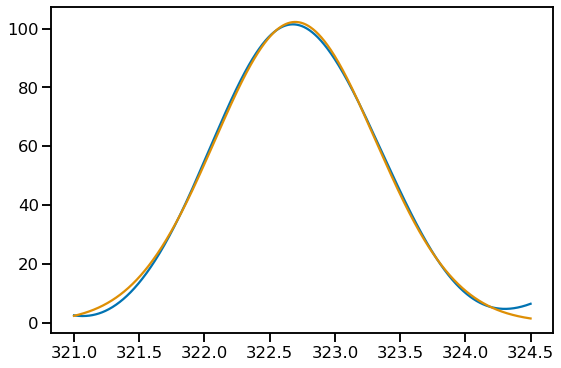

In [9]:
# f_arr, z_prob = efold_search(events[0], f_min=1/326, f_max=1/320, f_steps=1000, nbin = 32, pi_min = 260, pi_max = PI_max, region_filter=True)

# plt.figure(figsize= (9,6))
# plt.step(1/f_arr, z_prob, where='mid')
# print(np.max(z_prob))
# print(f_arr[np.argmax(z_prob)])

# f_arr, z_prob = efold_search(events[1], f_min=1/326, f_max=1/320, f_steps=1000, nbin = 32, pi_min = 260, pi_max = PI_max, region_filter=True)

# plt.figure(figsize= (9,6))
# plt.step(1/f_arr, z_prob, where='mid')
# print(np.max(z_prob))
# print(f_arr[np.argmax(z_prob)])

f_arr, z_prob, z_stat = efold_search_AandB(events[0], events[1], f_min=1/324.5, f_max=1/321, f_steps=1000, nbin = 32, pi_min = 260, pi_max = PI_max)

popt, pcov = scipy.optimize.curve_fit(gauss, 1/f_arr, z_stat, p0 = [100,322.7,0.5])
print(popt)
print(np.sqrt(np.diag(pcov)))

plt.figure(figsize= (9,6))
plt.plot(1/f_arr, z_stat)
plt.plot(1/f_arr, gauss(1/f_arr, *popt))
print(np.max(z_prob))
print(f_arr[np.argmax(z_prob)])

sorted_prob = np.argsort((1-z_prob))
summed = np.cumsum((1-z_prob)[sorted_prob])
print(f_arr[sorted_prob[np.argmin(summed-0.32)]])
print(np.min([np.min(events[0].time), np.min(events[1].time)]))


0.2723735408560311
0.02450300617150256


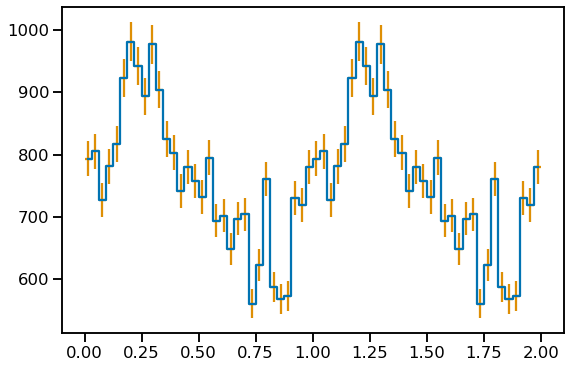

In [12]:
# events_merged = events[0].join(events[1])
# phase_bins, profile, profile_err, z_stat = events[0].fold_events(0.0030993800549015274, nbin = 32, ref_time = events[0].time[0], region_filter=True, pi_min=260, pi_max=PI_max)

# plt.figure(figsize= (9,6))
# plt.step(np.concatenate([phase_bins, 1.0 + phase_bins]), np.concatenate([profile, profile]), where='mid')
# plt.errorbar(np.concatenate([phase_bins, 1.0 + phase_bins]), np.concatenate([profile, profile]), xerr=1/32, yerr=np.concatenate([profile_err, profile_err]), ls='')

# phase_bins, profile, profile_err, z_stat = events[1].fold_events(0.0030993800549015274, nbin = 32, ref_time = events[0].time[0], region_filter=True, pi_min=260, pi_max=PI_max)

# plt.figure(figsize= (9,6))
# plt.step(np.concatenate([phase_bins, 1.0 + phase_bins]), np.concatenate([profile, profile]), where='mid')
# plt.errorbar(np.concatenate([phase_bins, 1.0 + phase_bins]), np.concatenate([profile, profile]), xerr=1/32, yerr=np.concatenate([profile_err, profile_err]), ls='')

A_mask = np.sqrt(np.square(events[0].x - events[0].centroid[0]) + np.square(events[0].y - events[0].centroid[1])) <= events[0].radius
B_mask = np.sqrt(np.square(events[1].x - events[1].centroid[0]) + np.square(events[1].y - events[1].centroid[1])) <= events[1].radius

temp_time = np.concatenate([events[0].time[A_mask], events[1].time[B_mask]])
sorted_arg = np.argsort(temp_time)
temp_time = temp_time[sorted_arg]
temp_pi = np.concatenate([events[0].pi[A_mask], events[1].pi[B_mask]])[sorted_arg]

joined_ev = EventList_ext(time=temp_time, gti=sting_gti.cross_two_gtis(events[0].gti, events[1].gti) , pi=temp_pi)

phase_bins, profile, profile_err, z_stat = joined_ev.fold_events(1/popt[1], nbin = 32, ref_time = joined_ev.time[0], region_filter=False, pi_min=PI_min, pi_max=PI_max)

plt.figure(figsize= (9,6))
plt.step(np.concatenate([phase_bins, 1.0 + phase_bins]), np.concatenate([profile, profile]), where='mid')
plt.errorbar(np.concatenate([phase_bins, 1.0 + phase_bins]), np.concatenate([profile, profile]), xerr=1/64, yerr=np.concatenate([profile_err, profile_err]), ls='')

PF = (np.max(profile)-np.min(profile))/(np.max(profile) + np.min(profile))

max_err = profile_err[np.argmax(profile)]
min_err = profile_err[np.argmin(profile)]
PF_err = np.sqrt(np.square((1-PF)*max_err) + np.square((1+PF)*min_err))/(np.max(profile) + np.min(profile))

print(PF)
print(PF_err)

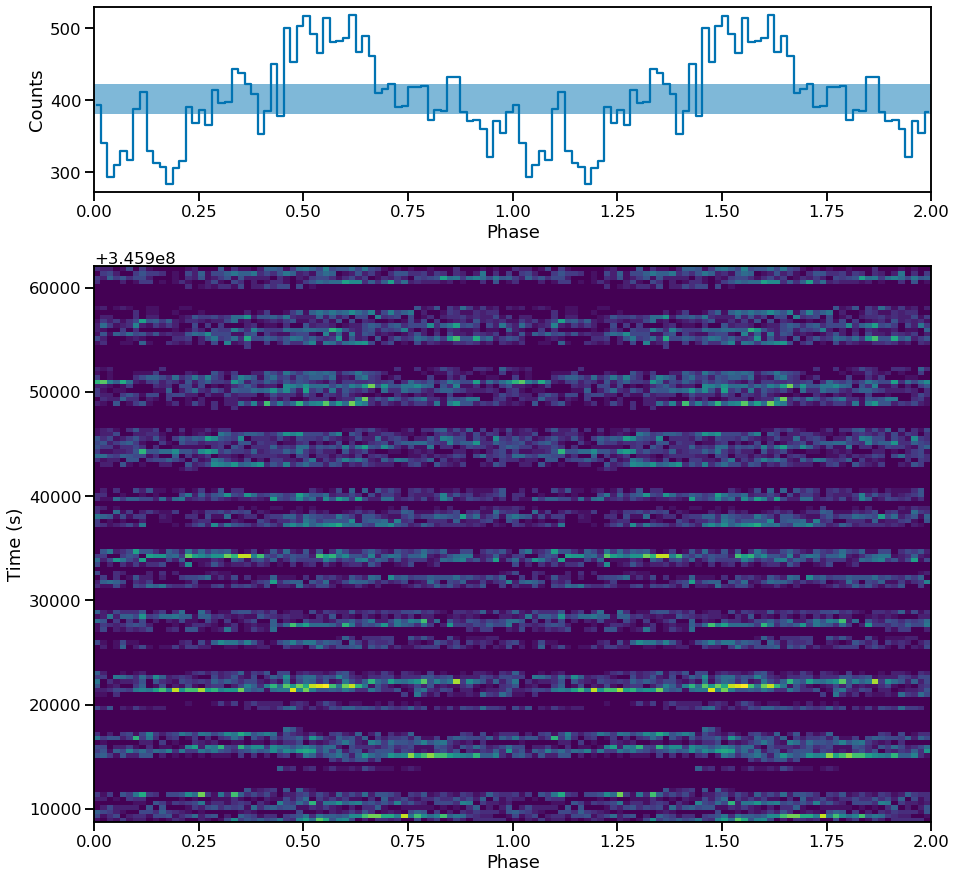

In [9]:
phaseogr, phases, times, additional_info = \
            phaseogram(joined_ev.time, 0.0030989770445291917, return_plot=True, nph=64, nt=128)

plt.figure(figsize=(15, 15))
gs = GridSpec(2, 1, height_ratios=(1, 3))
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

mean_phases = (phases[:-1] + phases[1:]) / 2
plot_profile(mean_phases, np.sum(phaseogr, axis=1), ax=ax0)
# Note that we can pass arguments to plt.pcolormesh, in this case vmin
_ = plot_phaseogram(phaseogr, phases, times, ax=ax1, vmin=np.median(phaseogr))
